In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from statistics import median
from operator import itemgetter
from scipy.stats import ttest_ind_from_stats
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
pd.options.mode.chained_assignment = None #gets rid of that annoying error message


In [45]:
def plot_sums_means_nans(df, value_cols):
    totals = df[value_cols].sum(axis=0)
    means = df[value_cols].mean(axis=0)
    nancounts = df[value_cols].isna().sum()
    contents = [totals, means, nancounts]
    titles = ['column totals', 'column means', 'column nan counts']
    
    fig, axs = plt.subplots(3, figsize=(6,3), sharex=True)
    
    for i, ax in enumerate(axs.flat):
        ax.bar(value_cols, contents[i])
        ax.set_title(titles[i], fontsize=10)
        ax.margins(x=0)
        ax.tick_params(axis='x', rotation=90)
        
    plt.subplots_adjust(hspace=0.4)

    
    
def boxplots(df, value_cols):
    fig, axs = plt.subplots(1,1, figsize=(8,4))
    df.boxplot(column=value_cols, grid=False, rot=45, fontsize=8)     
    
    
    
def histograms(df, value_cols):
    #cols = df.columns[value_cols].to_list()
    params = {'axes.titlesize':'8',
              'xtick.labelsize':'7',
              'ytick.labelsize':'7', 
              'axes.titley': '0.7'}
    plt.rcParams.update(params)
    df.hist(column=value_cols, 
            alpha=0.5, 
            bins=50, 
            grid=True, 
            sharex=True, sharey=True, 
            xlabelsize=6, ylabelsize=6,
            figsize=(9,9))
    plt.subplots_adjust(hspace=0.1, wspace=0.1) 
    plt.show()

    
    
def xy_plots(df, value_cols, ncols):
    nrows = df.shape[1] // ncols + (df.shape[1] % ncols > 0)
    cols = value_cols
    fig, axs = plt.subplots(nrows,ncols, figsize=(8,8), sharex=True, sharey=True)
    for i in range(len(cols)-1):
        axs.flat[i].scatter(df[cols[i]], df[cols[i+1]], s=5, alpha=0.6)
        axs.flat[i].set_title(f'{cols[i]} vs {cols[i+1]}', fontsize=8)
        ymin, ymax = axs.flat[i].get_ylim()
        axs.flat[i].axline([ymax*0.5,ymax*0.5], slope=1, c='r', lw=0.5)    
    plt.subplots_adjust(wspace=0.05, hspace=0.2)


    
def remove_rows(df, grpsize1, grpsize2):
    cols = df.columns
    if grpsize1 == 4 and grpsize2 == 4:
        df = df.drop(df[(df.iloc[:,-1] == 2) & (df.iloc[:,-2] == 1)].index)
        df = df.drop(df[(df.iloc[:,-1] == 1) & (df.iloc[:,-2] == 2)].index)
        df = df.drop(df[(df.iloc[:,-1] == 0) & (df.iloc[:,-2] == 2)].index)
        df = df.drop(df[(df.iloc[:,-1] == 2) & (df.iloc[:,-2] == 0)].index)
        df = df.drop(df[(df.iloc[:,-1] == 1) & (df.iloc[:,-2] == 1)].index)
        df = df.drop(df[(df.iloc[:,-1] == 0) & (df.iloc[:,-2] == 1)].index)
        df = df.drop(df[(df.iloc[:,-1] == 1) & (df.iloc[:,-2] == 0)].index)
        df = df.drop(df[(df.iloc[:,-1] == 0) & (df.iloc[:,-2] == 0)].index)
        df.loc[df[cols[-2]] == 0, cols[:4]] = [0,0,0,0]
        df.loc[df[cols[-1]] == 0, cols[4:8]] = [0,0,0,0]
        df.loc[df[cols[-2]] == 1, cols[-2]] = 2
        df.loc[df[cols[-1]] == 1, cols[-1]] = 2
        return df
    if grpsize1 == 3 or grpsize2 == 3:
        df = df.drop(df[(df.iloc[:,-1] == 1) & (df.iloc[:,-2] == 1)].index)
        df = df.drop(df[(df.iloc[:,-1] == 0) & (df.iloc[:,-2] == 1)].index)
        df = df.drop(df[(df.iloc[:,-1] == 1) & (df.iloc[:,-2] == 0)].index)
        df = df.drop(df[(df.iloc[:,-1] == 0) & (df.iloc[:,-2] == 0)].index)
        if grpsize2 == 3:
            df.loc[df[cols[-2]] == 0, cols[:4]] = [0,0,0,0]#######################
            df.loc[df[cols[-1]] == 0, cols[4:7]] = [0,0,0]
        if grpsize1 == 3:
            df.loc[df[cols[-2]] == 0, cols[:3]] = [0,0,0]
            df.loc[df[cols[-1]] == 0, cols[3:7]] = [0,0,0,0]
        if grpsize1 == 3 and grpsize2 == 4:
            df.loc[df[cols[-4]] == 0, cols[:3]] = [0,0,0]
            df.loc[df[cols[-1]] == 0, cols[3:6]] = [0,0,0]
        df.loc[df[cols[-2]] == 1, cols[-2]] = 2
        df.loc[df[cols[-1]] == 1, cols[-1]] = 2
    return df
    

    
def prpn_log2FCs_over_threshold(df, thresh_int):    
    fcs = df['grp1grp2_FC'].to_list()
    totalpos = len(([i for i in fcs if i > 0]))
    totalneg = len(([i for i in fcs if i < 0]))
    over_pos_thresh = len([i for i in fcs if i >= thresh_int])
    over_neg_thresh = len([i for i in fcs if i <= -thresh_int])
    prpn_pos = (over_pos_thresh/totalpos)*100 
    pos_pct = "{:.2f}".format(prpn_pos)
    prpn_neg = (over_neg_thresh/totalneg)*100
    neg_pct = "{:.2f}".format(prpn_neg)
    return pos_pct, neg_pct



def make_znorm(df):
    valuecols = df.columns.to_list()
    for col in valuecols:
        df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    df += 10
    return df



def ttest_from_stats_eqvar(df):

    tt_res = ttest_ind_from_stats(mean1 = df['zmean_grp1'], std1 = df['zstd_grp1'], nobs1 = df['znobs_grp1'], 
                                  mean2 = df['zmean_grp2'], std2 = df['zstd_grp2'], nobs2 = df['znobs_grp2'],
                                  equal_var=True)
    df['pvals'] = tt_res[1].tolist() #to_list
    df['Tpvals'] = -1*np.log2(tt_res[1].tolist()) #to_list

    tt_res = ttest_ind_from_stats(mean1 = df['zmean_grp1'], std1 = df['zstd_grp1_q95'], nobs1 = df['znobs_grp1_q95'], 
                                  mean2 = df['zmean_grp2'], std2 = df['zstd_grp2_q95'], nobs2 = df['znobs_grp2_q95'], 
                                  equal_var=True)
    df['pvals_q95'] = tt_res[1].tolist() #to_list
    df['Tpvals_q95'] = -1*np.log2(tt_res[1].tolist()) #to_list
    return df



def pvalFC_hists(plotdictkey):
    df = plotdict[plotdictkey]
    fig, axs = plt.subplots(1,2, figsize = (8,2), sharex='col', sharey=False)
    pvals = df['pvals'].to_list()
    FCs = df['grp1grp2_FC'].to_list()
    axs[0].hist(pvals, bins=50)
    axs[0].set_title(f'p-value distrbution for {plotdictkey}', fontsize=6)
    axs[1].hist(FCs, bins=50)
    axs[1].set_title(f'fold change distribution for {plotdictkey}', fontsize=6)
    axs[0].set_ylabel('frequency', fontsize=6)
    axs[0].set_xlabel('value', fontsize=6)
    axs[1].set_xlabel('value', fontsize=6)

    
    
    
def get_bins(plotdictkey):
    df = plotdict[plotdictkey]
    FCs = df['grp1grp2_FC'].to_list()
    fcmin = np.nanmin(FCs)
    fcmax = np.nanmax(FCs)
    counts, edges = np.histogram(FCs, bins=50, range=(fcmin, fcmax))
    return(counts, edges)



def get_xlist(df_pair):
    counts, edges = get_bins(df_pair)

    xmin = None
    xmax = None

    for i in range(len(counts)-1):
        xmin = np.ceil(min(edges)-1)
        xmax = float(math.floor(max(edges)+1))

    xtemp = [abs(xmin), abs(xmax)]
    biggest = max(xtemp)
    xlist = [-biggest, biggest]
    
    return xlist



def get_splitxlist(df_pair):
    counts, edges = get_bins(df_pair)
    xmiddles = []

    x0 = None
    x1 = None
    x2 = None
    x3 = None
    x4 = None
    x5 = None

    xmin = None
    xmax = None

    for i in range(len(counts)-1):
        if counts[i] != 0 and counts[i+1] == 0 and counts[i+2] == 0 and counts[i+3] == 0:
            xmiddles.append(edges[i+3])
        else:
            xmin = np.ceil(min(edges)-1)
            xmax = float(math.floor(max(edges)+1))

    x0 = np.ceil(min(edges)-1)
    x1 = np.ceil(xmiddles[0]-1)
    x2 = np.ceil(-xmiddles[1])
    x3 = float(math.floor(xmiddles[1]))
    x4 = float(math.floor(abs(xmiddles[0])+1))
    x5 = float(math.floor(max(edges)+1))

    splitxlist = [x0, x1, x2, x3, x4, x5]
    splitxlist = sorted(splitxlist)
    
    return splitxlist


In [46]:
##enter the name of your DIA results text file (protein-level, not peptide-level):

filename = 'VolcCLI_PD3.xlsx'

In [47]:
##enter the name of the software used to process your data ('DIANN', 'MaxQuant', 'ProteomeDiscoverer'):

software = 'ProteomeDiscoverer'

In [48]:
##Do you want to remove keratin contaminants (type True/False)?

rm_contaminants_reverses = True


In [49]:
if '.xls' in filename:
    df = pd.read_excel(filename)

if '.txt' in filename:
    df = pd.read_table(filename)
    
if '.csv' in filename:
    df = pd.read_csv(filename)

df = df.replace(0, np.nan)

pre_cull = df.shape


if rm_contaminants_reverses and software == 'DIANN':
    df = df[df['First.Protein.Description'].str.contains('Keratin') == False]
    
if rm_contaminants_reverses and software == 'MaxQuant':
    df = df[df['Majority protein IDs'].str.startswith('CON_')==False]
    df = df[df['Majority protein IDs'].str.startswith('REV_')==False]

if rm_contaminants_reverses and software == 'ProteomeDiscoverer':
    df = df[df['Description'].str.contains('Keratin') == False]


post_cull = df.shape

culled_rows = pre_cull[0] - post_cull[0]
print(f'{culled_rows} rows from {pre_cull[0]} rows were removed')

15 rows from 349 rows were removed


In [50]:
# now examine how your columns are currently named (suffixes are appended to repeat column names): 

print('current column names:', '\n',  list(df.columns))

current column names: 
 ['Checked', 'Protein FDR Confidence: Combined', 'Master', 'Accession', 'Description', 'Exp. q-value: Combined', 'Sum PEP Score', 'Coverage [%]', '# Peptides', '# PSMs', '# Unique Peptides', '# Protein Groups', '# AAs', 'MW [kDa]', 'calc. pI', 'Score Mascot: Mascot', '# Peptides (by Search Engine): Mascot', '# Razor Peptides', 'Abundance Ratio: (F1, 127N) / (F1, 126)', 'Abundance Ratio: (F1, 127C) / (F1, 126)', 'Abundance Ratio: (F1, 128N) / (F1, 126)', 'Abundance Ratio: (F1, 128C) / (F1, 126)', 'Abundance Ratio: (F1, 129N) / (F1, 126)', 'Abundance Ratio: (F1, 129C) / (F1, 126)', 'Abundance Ratio: (F1, 130N) / (F1, 126)', 'Abundance Ratio: (F1, 130C) / (F1, 126)', 'Abundance Ratio: (F1, 131N) / (F1, 126)', 'Abundance Ratio: (F1, 131C) / (F1, 126)', 'Abundance Ratio: (F1, 132N) / (F1, 126)', 'Abundance Ratio: (F1, 132C) / (F1, 126)', 'Abundance Ratio: (F1, 133N) / (F1, 126)', 'Abundance Ratio: (F1, 133C) / (F1, 126)', 'Abundance Ratio: (F1, 134N) / (F1, 126)', 'Fy

In [51]:
##from the current column names, type in the ones you want (keep the order the same for now):
wanted_columns = ['Accession', 'Description', 
                  'Fya-b-', 'Fya+b+', 'Fya+b-', 
                  'Fya-b+', 'Fya+b-.1', 'Fya+b+.1', 
                  'Fya-b-.1', 'Fya-b+.1', 'Fya+b+.2', 
                  'Fya-b+.2', 'Fya+b+.3', 'Fya-b-.2', 
                  'Fya-b+.3', 'Fya+b+.4', 'Fya+b-.2', 
                  'Fya-b-.3']
 
print('You are keeping the following columns:')
for i in wanted_columns:
    print(i)

You are keeping the following columns:
Accession
Description
Fya-b-
Fya+b+
Fya+b-
Fya-b+
Fya+b-.1
Fya+b+.1
Fya-b-.1
Fya-b+.1
Fya+b+.2
Fya-b+.2
Fya+b+.3
Fya-b-.2
Fya-b+.3
Fya+b+.4
Fya+b-.2
Fya-b-.3


In [52]:
# if you're happy with your column selection, type True
proceed = True

df = df[wanted_columns]


In [53]:
##now change the names to something that makes sense to you (again, keep the order the same for now):
better_column_names = ['Accession', 
                       'Description', 
                  'Fya-b-1', 'Fya+b+1', 'Fya+b-1', 
                  'Fya-b+1', 'Fya+b-2', 'Fya+b+2', 
                  'Fya-b-2', 'Fya-b+2', 'Fya+b+3', 
                  'Fya-b+3', 'Fya+b+4', 'Fya-b-3', 
                  'Fya-b+4', 'Fya+b+5', 'Fya+b-3', 
                  'Fya-b-4']

df.columns = better_column_names


In [54]:
##now change the order of 'better_column_names' to an order that makes sense to you (keeping the names the same):
better_column_order = ['Accession', 
                       'Description', 
                      'Fya-b-1', 
                        'Fya-b-2',
                       'Fya-b-3',
                       'Fya-b-4',
                       'Fya+b+1',
                        'Fya+b+2',
                        'Fya+b+3',
                         'Fya+b+4',
                       'Fya+b+5',
                      'Fya-b+1',
                        'Fya-b+2', 
                       'Fya-b+3',
                       'Fya-b+4',
                       'Fya+b-1', 
                       'Fya+b-2',
                       'Fya+b-3']

if len(df.columns) != len(better_column_names):
    print("make sure this list of columns names is the same length as the previous one")
 

In [55]:
#Choose which column you want to use to name all your data points e.g. 'Genes', 'Majority protein IDs'
index_col = 'Accession'
df.set_index(index_col, inplace=True)
    

In [56]:
#List the column names which contain your numeric data

value_cols = ['Fya-b-1', 
                        'Fya-b-2',
                       'Fya-b-3',
                       'Fya-b-4',
                       'Fya+b+1',
                        'Fya+b+2',
                        'Fya+b+3',
                         'Fya+b+4',
                       'Fya+b+5',
                      'Fya-b+1',
                        'Fya-b+2', 
                       'Fya-b+3',
                       'Fya-b+4',
                       'Fya+b-1', 
                       'Fya+b-2',
                       'Fya+b-3']

numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

tempdf = df.select_dtypes(include=numerics)

nonnumerics = [i for i in value_cols if i not in list(tempdf.columns)]

if len(nonnumerics) > 0:
    for i in nonnumerics:
        print('check if the following column contains non-numeric data:', ' ', i)
        

In [57]:
print('your data now has the following structure:')
df.head(10)

your data now has the following structure:


,Description,Fya-b-1,Fya+b+1,Fya+b-1,Fya-b+1,Fya+b-2,Fya+b+2,Fya-b-2,Fya-b+2,Fya+b+3,Fya-b+3,Fya+b+4,Fya-b-3,Fya-b+4,Fya+b+5,Fya+b-3,Fya-b-4
Accession,,,,,,,,,,,,,,,,,
P02549,"Spectrin alpha chain, erythrocytic 1 OS=Homo s...",7138.0,26287.6,18464.5,10857.2,5579.1,17878.5,7879.1,20206.3,11884.6,9036.6,27045.2,24377.5,8514.1,15594.8,20959.5,21485.0
P02730,Band 3 anion transport protein OS=Homo sapiens...,82597.3,90740.8,70587.7,82772.2,79394.3,83982.3,83009.7,75311.9,64122.6,78513.2,57655.6,71054.1,96380.6,70184.0,67423.1,82674.4
P16157,Ankyrin-1 OS=Homo sapiens (Human) OX=9606 GN=A...,18732.3,29857.8,22910.6,29899.1,17969.8,25456.4,17532.0,18362.2,18060.8,22663.5,30024.1,27056.2,21695.8,22227.8,20395.9,25061.6
P11277,"Spectrin beta chain, erythrocytic OS=Homo sapi...",6715.1,25029.6,14970.6,9682.3,5060.2,12022.5,6052.4,14819.7,8286.6,7778.3,22509.3,18164.9,6803.2,11993.1,16800.3,14051.7
P50895,Basal cell adhesion molecule OS=Homo sapiens (...,17238.9,8830.1,17970.4,21845.7,14496.1,11412.3,13685.7,24911.5,15226.1,16581.2,8251.1,17258.1,10934.9,13451.2,21166.2,14651.0
P17927,Complement receptor type 1 OS=Homo sapiens (Hu...,11087.7,9074.1,11454.6,9981.1,19652.6,11151.8,7806.4,4363.5,8783.6,7384.7,10136.8,6614.9,15457.4,8739.4,14274.0,17475.8
Q92508,Piezo-type mechanosensitive ion channel compon...,9014.5,10947.0,11793.9,11639.3,10818.9,11579.1,9888.5,9154.3,7899.1,8906.3,7775.5,11623.9,11249.3,9736.6,9719.7,12577.0
P23276,Kell blood group glycoprotein OS=Homo sapiens ...,13560.8,16296.0,11906.8,12772.8,11704.1,13789.4,14302.7,12106.1,10730.6,12107.1,8498.7,13449.6,15625.0,10677.9,14015.0,15071.7
O15439,Multidrug resistance-associated protein 4 OS=H...,16809.8,11129.5,11973.1,13902.3,12033.4,12031.4,18046.0,12268.9,9356.7,14064.2,8116.1,14982.0,14952.1,12739.1,13183.7,17503.4


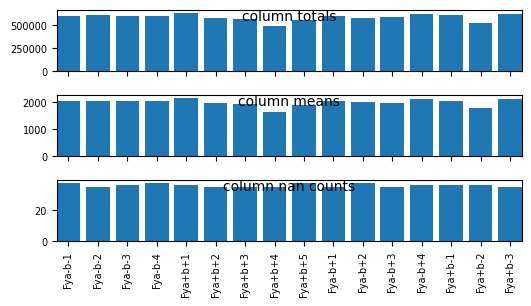

In [58]:
##take a look at the total, means and missing value counts.
plot_sums_means_nans(df, value_cols)

In [59]:
# type the name of any columns you want to drop between the square brackets below:
# e.g. ['MCP4', 'OCP2']
# or leave blank i.e.   columns_to_drop = []    if you don't want to drop any

columns_to_drop = []
df = df.drop(columns=columns_to_drop)

print('previous numeric columns:', value_cols, '\n')
value_cols = [col for col in value_cols if col not in columns_to_drop]
print('updated numeric columns:', value_cols)

previous numeric columns: ['Fya-b-1', 'Fya-b-2', 'Fya-b-3', 'Fya-b-4', 'Fya+b+1', 'Fya+b+2', 'Fya+b+3', 'Fya+b+4', 'Fya+b+5', 'Fya-b+1', 'Fya-b+2', 'Fya-b+3', 'Fya-b+4', 'Fya+b-1', 'Fya+b-2', 'Fya+b-3'] 

updated numeric columns: ['Fya-b-1', 'Fya-b-2', 'Fya-b-3', 'Fya-b-4', 'Fya+b+1', 'Fya+b+2', 'Fya+b+3', 'Fya+b+4', 'Fya+b+5', 'Fya-b+1', 'Fya-b+2', 'Fya-b+3', 'Fya-b+4', 'Fya+b-1', 'Fya+b-2', 'Fya+b-3']


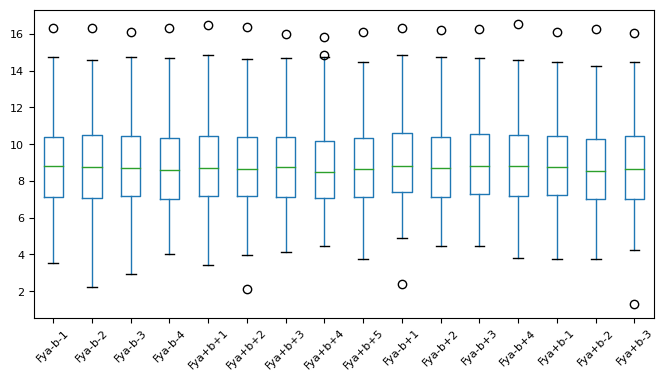

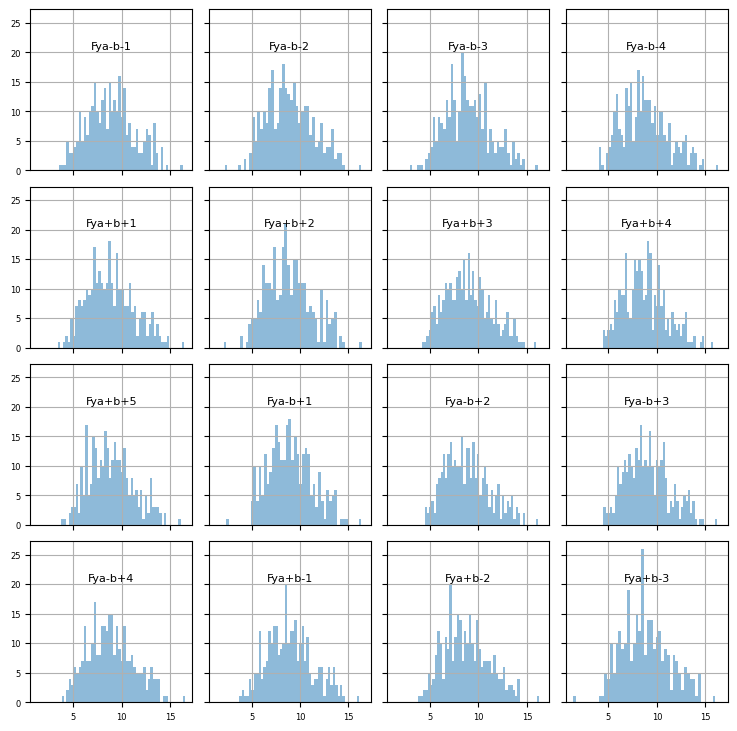

In [60]:
##examine the log2-transformed data and make sure nothing else looks too weird:

df = np.log2(df[value_cols])

boxplots(df, value_cols)
histograms(df, value_cols)

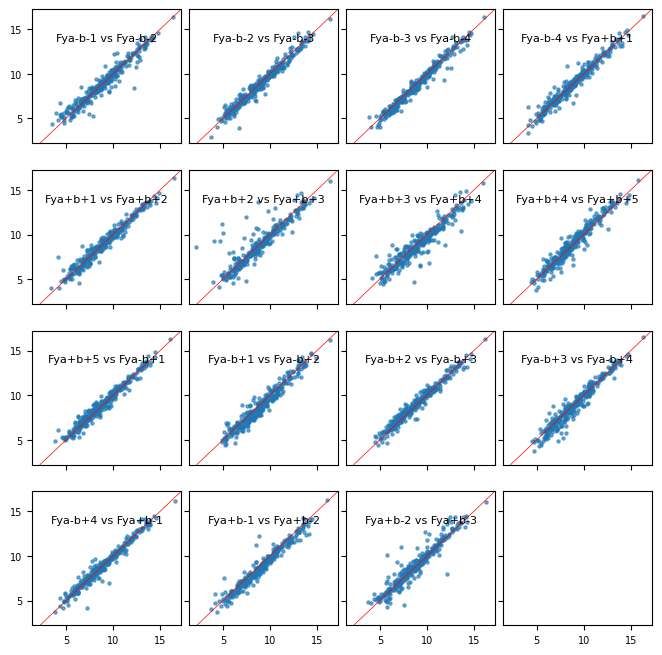

In [61]:
#most of your proteins should have roughly the same value between replicates
#plot adjacent replicates and see if values fall arouns and xy line

#first choose the number of subplots per row in your figure
#if you have up to 6 numeric columns, put in the number of numeric column you have
#if you have more than 6 numeric columns, start with 6 and see how it looks. 

ncols = 4
xy_plots(df, value_cols, ncols)

In [62]:
# this script makes pairwise comparisons, so numeric columns need to be assigned to pairs
# each pair consistent of two groups
# e.g. control_group vs expt1_group or control_group vs expt2_group or expt1_group vs expt2_group.


# first assign column names to groupsusing the following format:
# you can have up to 10 groups, where grp0 is the first group and grp10 is the last group.

grp0 = ['Fya-b-1', 'Fya-b-2','Fya-b-3', 'Fya-b-4' ]
grp1 = ['Fya+b+1', 'Fya+b+2', 'Fya+b+3', 'Fya+b+4', 'Fya+b+5']
grp2 = ['Fya-b+1', 'Fya-b+2', 'Fya-b+3', 'Fya-b+4']
grp3 = ['Fya+b-1', 'Fya+b-2', 'Fya+b-3']
grp4 = []
grp5 = []
grp6 = []
grp7 = []
grp8 = []
grp9 = []



In [63]:
# now decide how you want to pair your groups using the following format:

pairs = [(grp0, grp1), (grp0, grp2), (grp0, grp3), (grp1, grp2)]

print('these are your pair names:')
for i in pairs:
    k = i[0][0][:-1] + '_' + i[1][0][:-1]
    print(k)

these are your pair names:
Fya-b-_Fya+b+
Fya-b-_Fya-b+
Fya-b-_Fya+b-
Fya+b+_Fya-b+


In [64]:
# How much change are you expecting to see in protein abundance?
# Set your fold change (FC) threshold here in log2 format (4 FC = log2(2), 2FC = log2(2), 1.5FC = log2(0.585))

log2FC = 2

same = log2FC

In [65]:
FCdict = {}
Zdict = {}

dftest = []
for i in pairs:
    cols = list(i[0]) + list(i[1])
    k = i[0][0][:-1] + '_' + i[1][0][:-1]
    df2 = df[cols]
    FCdict[k] = [df2, i[0], i[1]]
    Zdict[k] = [df2, i[0], i[1]]
     
        
overFCthresh = {}
dfnames = []
FCdfs = []
for k, v in FCdict.items():
    df = v[0]
    grp1 = [c for c in df.columns if c in v[1]]
    grp2 = [c for c in df.columns if c in v[2]]
    
    df['nobs_grp1'] = df.loc[:,grp1].count(axis=1)
    df['nobs_grp2'] = df.loc[:,grp2].count(axis=1)
    df = remove_rows(df, len(grp1), len(grp2))
    df = df.drop(columns = ['nobs_grp1', 'nobs_grp2'])

    df['mean_grp1'] = df.loc[:,grp1].mean(axis=1)
    df['mean_grp2'] = df.loc[:,grp2].mean(axis=1)
    df['grp1grp2_FC'] = df['mean_grp1'] - df['mean_grp2']
    
    FCdfs.append(df)
    dfnames.append(k)
    
    p, n = prpn_log2FCs_over_threshold(df, log2FC)
    overFCthresh[k] = (p, n)
    
    

Zdfs = []
q95s = []
for k, v in Zdict.items():
    df = v[0]
    grp1 = [c for c in df.columns if c in v[1]]
    grp2 = [c for c in df.columns if c in v[2]]
    
    df = make_znorm(df)
    df['nobs_grp1'] = df.loc[:,grp1].count(axis=1)
    df['nobs_grp2'] = df.loc[:,grp2].count(axis=1)
    df = remove_rows(df, len(grp1), len(grp2))
    df = df.drop(columns = ['nobs_grp1', 'nobs_grp2'])
    
    df['zmean_grp1'] = df.loc[:,grp1].mean(axis=1)
    df['zstd_grp1'] = df.loc[:,grp1].std(axis=1)
    q95grp1 = df.zstd_grp1.quantile(q=0.95)
    df['zstd_grp1_q95'] = df['zstd_grp1'].fillna(q95grp1)
    df['znobs_grp1'] = df.loc[:,grp1].count(axis=1)    
    df['znobs_grp1_q95'] = np.where(df['znobs_grp1'] == 1, 2, df['znobs_grp1'])
    df['zmean_grp2'] = df.loc[:,grp2].mean(axis=1)
    df['zstd_grp2'] = df.loc[:,grp2].std(axis=1)
    q95grp2 = df.zstd_grp2.quantile(q=0.95)
    df['zstd_grp2_q95'] = df['zstd_grp2'].fillna(q95grp2)
    df['znobs_grp2'] = df.loc[:,grp2].count(axis=1)
    df['znobs_grp2_q95'] = np.where(df['znobs_grp2'] == 1, 2, df['znobs_grp2'])
    
    df = ttest_from_stats_eqvar(df)
    
    q95 = (q95grp1, q95grp2)
    q95s.append(q95)
    
    Zdfs.append(df)

FZdfs = []
for i, df in enumerate(FCdfs):
    FZdf = pd.concat([df, Zdfs[i]], axis=1)
    FZdfs.append(FZdf[['grp1grp2_FC', 'pvals', 'Tpvals', 'Tpvals_q95', 'zstd_grp1_q95', 'zstd_grp2_q95']])
    
plotdict = dict(zip(dfnames, FZdfs))
q95dict = dict(zip(dfnames, q95s))

In [66]:
##review that you're about the plot the expected pairs
##review what percentage of proteins will be higher-lower than the positive-negative fold change limits

for k, v in plotdict.items():
    print('you are plotting these pairs:', k)
    
for k, v in overFCthresh.items():
    print(f'percent of proteins if log2 fold-change is {log2FC}:',k, v)

you are plotting these pairs: Fya-b-_Fya+b+
you are plotting these pairs: Fya-b-_Fya-b+
you are plotting these pairs: Fya-b-_Fya+b-
you are plotting these pairs: Fya+b+_Fya-b+
percent of proteins if log2 fold-change is 2: Fya-b-_Fya+b+ ('0.00', '1.49')
percent of proteins if log2 fold-change is 2: Fya-b-_Fya-b+ ('0.00', '0.57')
percent of proteins if log2 fold-change is 2: Fya-b-_Fya+b- ('0.60', '0.75')
percent of proteins if log2 fold-change is 2: Fya+b+_Fya-b+ ('0.00', '0.00')


In [67]:
# if you got too high or low a %age of proteins over the FC threshold, type your new number instead of 'same'
# to keep it the same, just leave it as is.

log2FC = 1.5


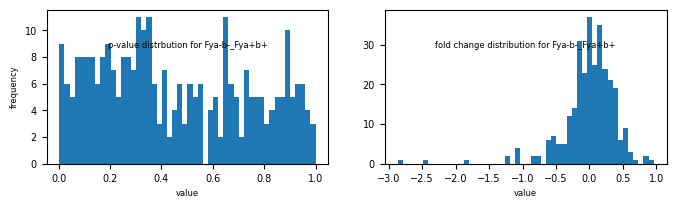

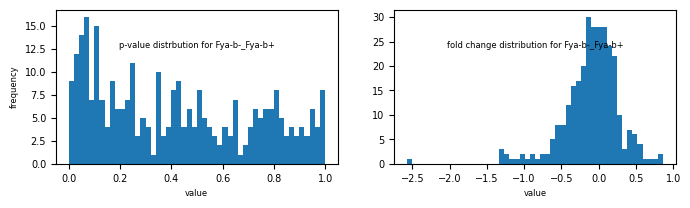

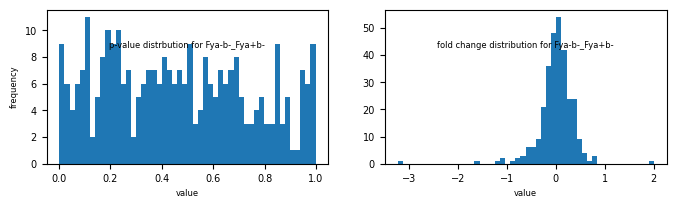

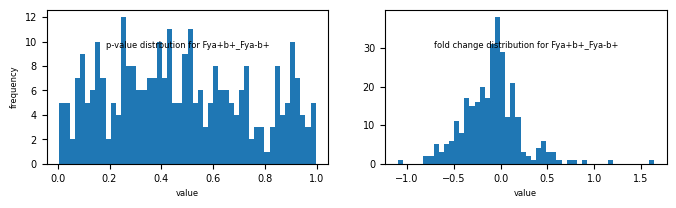

In [68]:
# now examine the distrbutions of p-values and fold changes for all your pairs. 
# the majority of fold changes should be normally distrbuted around zero
# the distrbution of p-values will depend on your experiment

for key in list(plotdict.keys()):
    pvalFC_hists(key)
    

In [69]:
# select any markers you'd like included in the plot. Format as: markers = ['gene_name1', 'gene_name2']

markers = []


In [70]:
# now select your p-value threshold:
# 4.32 for p=0.05, #6.64 for p=0.01, #9.96 for p=0.01. Or set to 0 for no threshold.

pthresh = 4.32


In [77]:
# you'll now produce a plot for one of your pairs
# name the pair using the names shown after "you are plotting these pairs:" earlier on
# e.g. for 'you are plotting these pairs: W_M', pair_name = 'W_M'

pair_name = 'Fya-b-_Fya+b+'
df_pair = [pair_name]


In [78]:
# If you expect a wide range of fold-changes, set split_xaxis to True (False if you don't, obviously)

split_xaxis = False


In [79]:
# Do you want to plot high-quality data points, or also proteins with only one datapoint in one group?
# These data points will be colored differently, so you can spot them easily
# (data points with only one in both groups cannot be plotted)

plot_high_quality_only = False


In [80]:
# If you do/don't want data points annotated on your plot, set 'label_significant_proteins' to True/False
# If you do/don't want a print out of names below your volcano plot, set print protein option to True/False

label_significant_proteins = True
print_significant_proteins = False


In [81]:
##choose colours for above the positive threshold and below the negative thresholds

color_pos = 'cyan'
color_neg = 'red'

# if you're plotting lower quality data point, select their colour

color_low = 'pink'


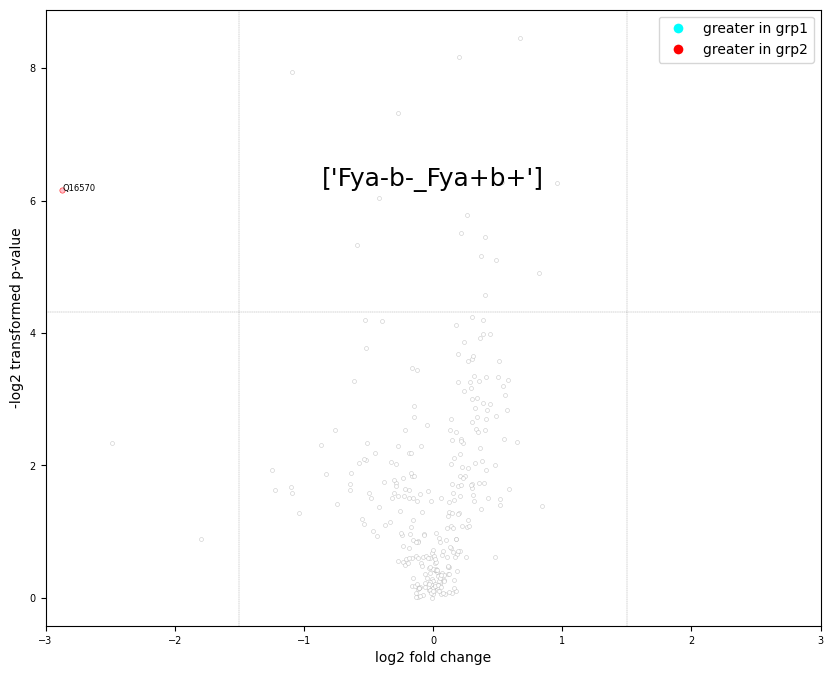

In [82]:
key = None
if len(df_pair) == 1:
    key = df_pair[0]
    
splitxlist = None
try:
    splitxlist = get_splitxlist(key)
except IndexError:
    print('x-axis range is not large enough for split x-axis. Set this option to False')


lw=0.25
ls = '--'

FClim = log2FC

pos_overFC = []
neg_overFC = []
betweenFCs = []

df = plotdict[key]

(q951, q952) = q95dict[key]

datacols = [df.index, df['grp1grp2_FC'], df['Tpvals'], df['Tpvals_q95'], df['zstd_grp1_q95'], df['zstd_grp2_q95']]

plotlist = [datacols[0], datacols[1], datacols[3], datacols[4], datacols[5]]


if plot_high_quality_only:
    plotlist = [datacols[0], datacols[1], datacols[2]]
    

if split_xaxis:
    fig, ax = plt.subplots(1, 3, figsize = (10,8), sharey=True)
    fig.subplots_adjust(wspace=0.05)

    a0 = ax.flat[0]
    a1 = ax.flat[1]
    a2 = ax.flat[2]

    a0.set_xlim(splitxlist[0], splitxlist[1])
    a1.set_xlim(splitxlist[2], splitxlist[3]) 
    a2.set_xlim(splitxlist[4], splitxlist[5])

    a1.axvline(FClim, ls=ls, c='k', alpha=0.5, lw=lw)
    a1.axvline(-FClim, ls=ls, c='k', alpha=0.5, lw=lw)
    for a in ax.flat:
        a.axhline(pthresh,ls=ls, c='k', alpha=0.5, lw=lw)

    a1.set_title(df_pair, fontsize=18)

    a0.spines['right'].set_visible(False)
    a1.spines['left'].set_visible(False)
    a1.spines['right'].set_visible(False)
    a2.spines['left'].set_visible(False)

    d = .8  
    kwargs = dict(marker=[(-1, -d), (1, d)], markersize=8,
                  linestyle="none", color='k', mec='k', mew=1, clip_on=False)
    a0.plot([1,1], [1,0], transform=a0.transAxes, **kwargs)
    a1.plot([0,0], [1,0], [1,1], [1,0], transform=a1.transAxes, **kwargs)
    a2.plot([0,0], [0,1], transform=a2.transAxes, **kwargs)
    a0.yaxis.tick_left()
    a0.set_ylabel('-log2 transformed p-value')
    a1.set_xlabel('log2 fold change')
    a2.yaxis.tick_right()
    a1.tick_params(axis='y', which='both',length=0)
    a1.set_yticks([])
    a2.yaxis.set_label_position("right")
    a2.set_yticks([0,5,10,15,20,25,30,35,40,45,50,55]) 
    
    for a in ax.flat:
        a.scatter(plotlist[1], plotlist[2], s=8, color='w', edgecolors='darkgrey', lw=lw)

    marker_text = []

    for i, name in enumerate(plotlist[0]):

        if name in markers:
            marker_text.append((plotlist[1][i], plotlist[2][i], name))
            for a in ax.flat:
                a.scatter(plotlist[1][i], plotlist[2][i], s=3, color='k')

        if plotlist[1][i] >= FClim and plotlist[2][i] >= pthresh:
            pos_overFC.append(name)
            for a in ax.flat:
                a.scatter(plotlist[1][i], plotlist[2][i], s=10, color=color_pos)
            if label_significant_proteins:
                a1.annotate(name, xy=(plotlist[1][i], plotlist[2][i]), fontsize=6)
                a2.annotate(name, xy=(plotlist[1][i], plotlist[2][i]), fontsize=6)

        if plotlist[1][i] <= -FClim  and plotlist[2][i] >= pthresh:
            neg_overFC.append(name)
            for a in ax.flat:
                a.scatter(plotlist[1][i], plotlist[2][i], s=10, color=color_neg)
            if label_significant_proteins:
                a0.annotate(name, xy=(plotlist[1][i], plotlist[2][i]), fontsize=6)
                a1.annotate(name, xy=(plotlist[1][i], plotlist[2][i]), fontsize=6)

        if not plot_high_quality_only:
            if plotlist[3][i] == q951 or plotlist[4][i] == q952:
                for a in ax.flat:
                    a.scatter(plotlist[1][i], plotlist[2][i], s=6, color=color_low)        


    for tx in marker_text:
        for a in ax.flat:
            a.annotate(tx[2], xy=(tx[0], tx[1]),  xytext=(tx[0], tx[1]),
                    arrowprops=dict(arrowstyle='-', fc="k", ec="k", lw=0.5, relpos=(0.25, 0.5)),
                    bbox=dict(pad=-2, facecolor="none", edgecolor="none"),
                    ha="left", va="center", size=6)
            
        

    legend_elements = [Line2D([0], [0], marker='o', color='w', label='greater in grp1',markerfacecolor=color_pos, markersize=8, linestyle=''), 
                       Line2D([0], [0], marker='o', color='w', label='greater in grp2',markerfacecolor=color_neg, markersize=8, linestyle='')]
    a1.legend(handles=legend_elements)

if not split_xaxis:
    
    xlims = get_xlist(key)
    
    fig, ax = plt.subplots(figsize = (10,8), sharey=True)
    
    ax.set_xlim(xlims[0], xlims[1])

    ax.axvline(FClim, ls=ls, c='k', alpha=0.5, lw=lw)
    ax.axvline(-FClim, ls=ls, c='k', alpha=0.5, lw=lw)
    ax.axhline(pthresh,ls=ls, c='k', alpha=0.5, lw=lw)

    ax.set_title(df_pair, fontsize=18)
    ax.set_ylabel('-log2 transformed p-value')
    ax.set_xlabel('log2 fold change')
        
    ax.scatter(plotlist[1], plotlist[2], s=8, color='w', edgecolors='darkgrey', lw=lw)

    marker_text = []

    for i, name in enumerate(plotlist[0]):

        if name in markers:
            marker_text.append((plotlist[1][i], plotlist[2][i], name))
            ax.scatter(plotlist[1][i], plotlist[2][i], s=3, color='k')

        if plotlist[1][i] >= FClim and plotlist[2][i] >= pthresh:
            pos_overFC.append(name)
            ax.scatter(plotlist[1][i], plotlist[2][i], s=10, color=color_pos)
            if label_significant_proteins:
                ax.annotate(name, xy=(plotlist[1][i], plotlist[2][i]), fontsize=6)

        if plotlist[1][i] <= -FClim  and plotlist[2][i] >= pthresh:
            neg_overFC.append(name)
            ax.scatter(plotlist[1][i], plotlist[2][i], s=10, color=color_neg)
            if label_significant_proteins:
                ax.annotate(name, xy=(plotlist[1][i], plotlist[2][i]), fontsize=6)

        if not plot_high_quality_only:
            if plotlist[3][i] == q951 or plotlist[4][i] == q952:
                ax.scatter(plotlist[1][i], plotlist[2][i], s=6, color=color_low)        

    for tx in marker_text:
            ax.annotate(tx[2], xy=(tx[0], tx[1]),  xytext=(tx[0], tx[1]),
                    arrowprops=dict(arrowstyle='-', fc="k", ec="k", lw=0.5, relpos=(0.25, 0.5)),
                    bbox=dict(pad=-2, facecolor="none", edgecolor="none"),
                    ha="left", va="center", size=6)
            
    legend_elements = [Line2D([0], [0], marker='o', color='w', label='greater in grp1',markerfacecolor=color_pos, markersize=8, linestyle=''), 
                       Line2D([0], [0], marker='o', color='w', label='greater in grp2',markerfacecolor=color_neg, markersize=8, linestyle='')]
    ax.legend(handles=legend_elements)

    plt.show()
    
    
if print_significant_proteins:
    print('greater in grp1:', pos_overFC)
    print('greater in grp2:', neg_overFC)
    